In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight


In [10]:
#Dataset (Oxford Pets con segmentaciones)
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
train = dataset['train']
test = dataset['test']

def preprocess(sample):
    image = tf.image.resize(sample['image'], (128, 128))
    mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    mask = tf.cast(mask, tf.uint8) - 1  # Quitar clase de fondo extra
    return image / 255.0, mask

train = train.map(preprocess).batch(16).prefetch(tf.data.AUTOTUNE)
test = test.map(preprocess).batch(16).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.DBWCG4_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.DBWCG4_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [11]:
#arquitectura de la UNET

def unet_model(output_channels):
    inputs = tf.keras.Input(shape=(128, 128, 3))
    # Downsampling
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    # Bottleneck
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    # Upsampling
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    outputs = layers.Conv2D(output_channels, 1, activation='softmax')(x)
    return models.Model(inputs, outputs)


In [12]:
#BALANCE DE CLASES

# Para simplificar, computamos las frecuencias globales de clases
def compute_class_distribution(dataset):
    total = []
    for _, mask in dataset.unbatch():
        flat_mask = tf.reshape(mask, [-1])
        total.extend(flat_mask.numpy())
    unique, counts = np.unique(total, return_counts=True)
    class_freq = dict(zip(unique, counts))
    return class_freq

class_freq = compute_class_distribution(train)
total_pixels = sum(class_freq.values())
class_weights = {k: total_pixels / (len(class_freq) * v) for k, v in class_freq.items()}
print("Class frequencies:", class_freq)
print("Class weights:", class_weights)


Class frequencies: {np.uint8(0): np.int64(18064032), np.uint8(1): np.int64(35926173), np.uint8(2): np.int64(6302915)}
Class weights: {np.uint8(0): np.float64(1.11258143623011), np.uint8(1): np.float64(0.559416853742442), np.uint8(2): np.float64(3.188636792129779)}


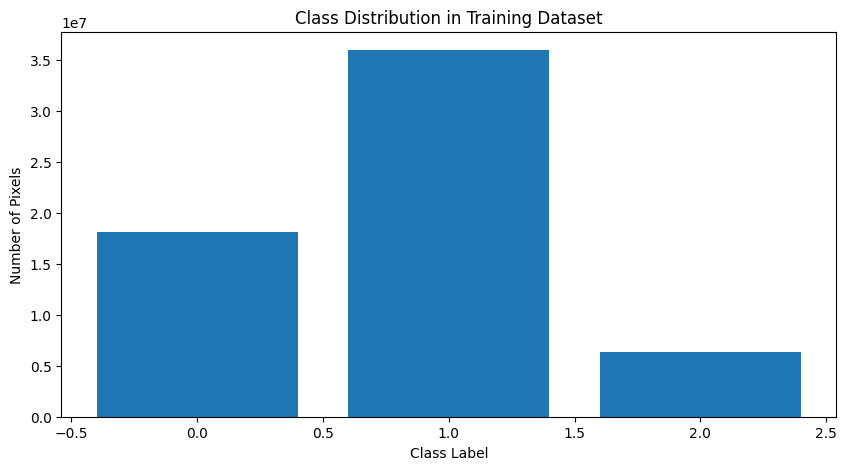

In [13]:
#GRAFICAR UN HISTOGRAMA DE LAS CLASES
plt.figure(figsize=(10, 5))
plt.bar(class_freq.keys(), class_freq.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Pixels")
plt.title("Class Distribution in Training Dataset")
plt.show()


In [14]:
#funciones para calcular las metricas
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    correct = tf.equal(tf.cast(y_true, tf.int64), y_pred_labels)
    return tf.reduce_mean(tf.cast(correct, tf.float32))

def mean_pixel_accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.reshape(y_pred, [-1])
    num_classes = tf.reduce_max(y_true) + 1
    mpa = []
    for c in range(num_classes):
        mask = tf.equal(y_true, c)
        correct = tf.equal(tf.boolean_mask(y_pred, mask), c)
        acc = tf.reduce_mean(tf.cast(correct, tf.float32))
        mpa.append(acc)
    return tf.reduce_mean(tf.stack(mpa))

def frequency_weighted_iou(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.reshape(y_pred, [-1])
    num_classes = tf.reduce_max(y_true) + 1
    total_pixels = tf.size(y_true)
    fwiou = 0
    for c in range(num_classes):
        true_c = tf.equal(y_true, c)
        pred_c = tf.equal(y_pred, c)
        inter = tf.reduce_sum(tf.cast(true_c & pred_c, tf.float32))
        union = tf.reduce_sum(tf.cast(true_c | pred_c, tf.float32))
        freq = tf.reduce_sum(tf.cast(true_c, tf.float32)) / tf.cast(total_pixels, tf.float32)
        fwiou += freq * (inter / (union + 1e-6))
    return fwiou


In [15]:
#entrenamos la red
model = unet_model(output_channels=3)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train, validation_data=test, epochs=10)


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2088s 9s/step - accuracy: 0.6076 - loss: 0.8533 - val_accuracy: 0.6306 - val_loss: 0.8265
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2078s 9s/step - accuracy: 0.7161 - loss: 0.6612 - val_accuracy: 0.7352 - val_loss: 0.6314
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2054s 9s/step - accuracy: 0.7469 - loss: 0.6051 - val_accuracy: 0.7194 - val_loss: 0.6492
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2021s 9s/step - accuracy: 0.7560 - loss: 0.5844 - val_accuracy: 0.7424 - val_loss: 0.6076
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2046s 9s/step - accuracy: 0.7701 - loss: 0.5576 - val_accuracy: 0.7716 - val_loss: 0.5531
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2040s 9s/step - accuracy: 0.7756 - loss: 0.5438 - val_accuracy: 0.7598 - val_loss: 0.5788
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2015s 9s/step - accuracy: 0.7844 - loss: 0.5269 - val_accuracy: 0.7853 - val_loss: 0.5268
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2042s 9s/step - accuracy: 0.7853 - loss: 0.5246 - 

In [16]:
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
model.save("my_model.keras")

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 3)    │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,219,531 (8.47 MB)

 Trainable params: 739,843 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,479,688 (5.64 MB)

In [20]:
import keras
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_model.keras")

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 3)    │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,219,531 (8.47 MB)

 Trainable params: 739,843 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,479,688 (5.64 MB)

Exactitud en el conjunto de prueba: 0.78


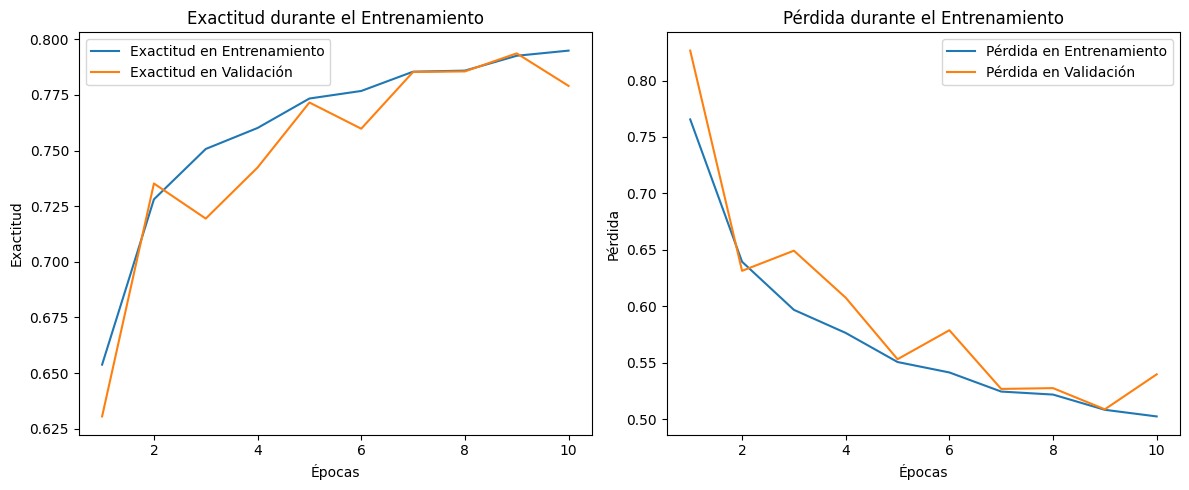

In [27]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test, verbose=0)
print(f"Exactitud en el conjunto de prueba: {test_acc:.2f}")

# Graficar la precisión y la pérdida del entrenamiento
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# Gráfico de la precisión
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Exactitud en Entrenamiento')
plt.plot(epochs, history.history['val_accuracy'], label='Exactitud en Validación')
plt.title('Exactitud durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Gráfico de la pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(epochs, history.history['val_loss'], label='Pérdida en Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Obtener una predicción sobre todo el test set
for images, masks in test.take(1):
    preds = model.predict(images)
    print(preds)
    '''
    print("IoU:", iou_metric(masks, preds).numpy())
    print("Dice Coef:", dice_coef(masks, preds).numpy())
    print("Pixel Acc:", pixel_accuracy(masks, preds).numpy())
    print("Mean Pixel Acc:", mean_pixel_accuracy(masks, preds).numpy())
    print("Frequency Weighted IoU:", frequency_weighted_iou(masks, preds).numpy())'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[[[6.60960446e-04 9.71867323e-01 2.74717994e-02]
   [7.17857911e-05 9.86155272e-01 1.37728201e-02]
   [4.62121898e-05 9.88101244e-01 1.18526295e-02]
   ...
   [2.73152633e-04 9.95514154e-01 4.21260344e-03]
   [3.73260118e-04 9.94629204e-01 4.99741873e-03]
   [1.88266812e-03 9.86416101e-01 1.17014032e-02]]

  [[1.35954033e-04 9.82175171e-01 1.76889338e-02]
   [1.53490382e-05 9.90194678e-01 9.79007222e-03]
   [1.01927781e-05 9.92833734e-01 7.15614762e-03]
   ...
   [1.77649752e-04 9.97743964e-01 2.07834085e-03]
   [1.78397022e-04 9.97924328e-01 1.89731852e-03]
   [5.08925645e-04 9.96542633e-01 2.94844015e-03]]

  [[1.38276155e-04 9.83669102e-01 1.61926001e-02]
   [2.13444437e-05 9.93363202e-01 6.61541428e-03]
   [1.57526301e-05 9.94978011e-01 5.00622997e-03]
   ...
   [2.04729949e-04 9.98505235e-01 1.28989562e-03]
   [1.61691423e-04 9.98630822e-01 1.20748568e-03]
   [4.10300039e-04 9.97448087e-01 2.14143191e-03]]

  ...

  [[6.49994821e-04 9.82636929e

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


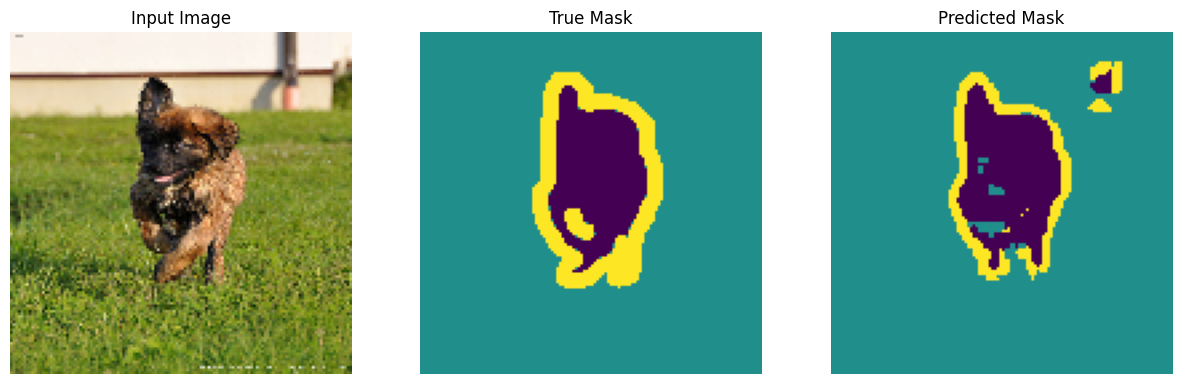

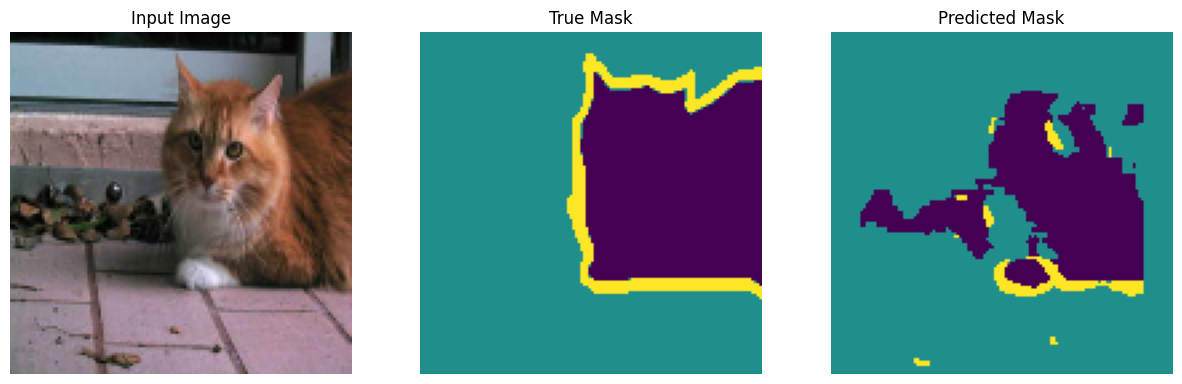

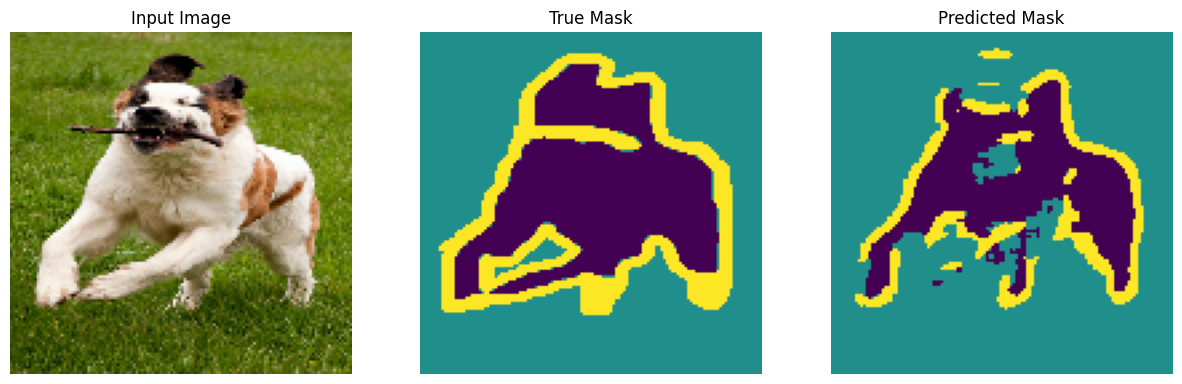

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


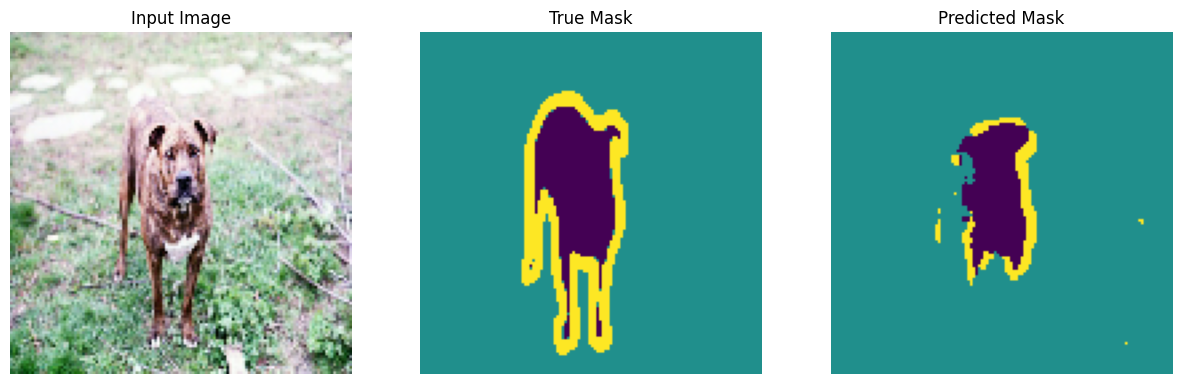

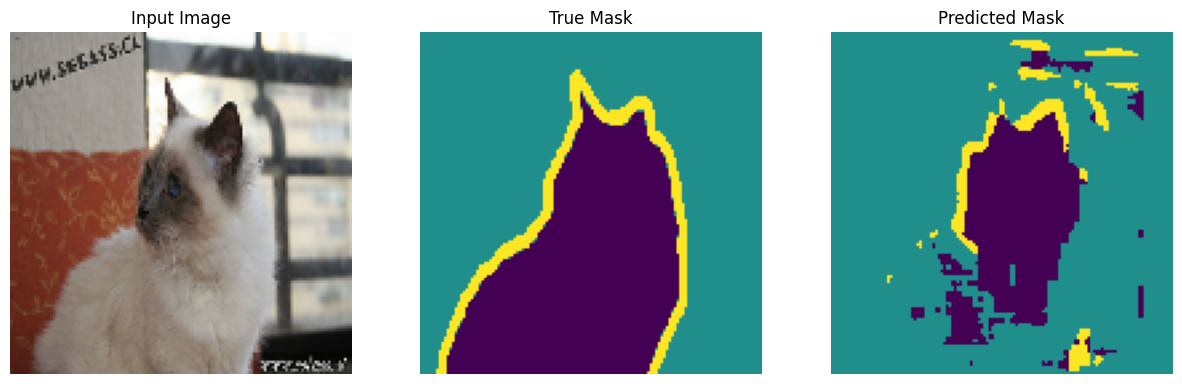

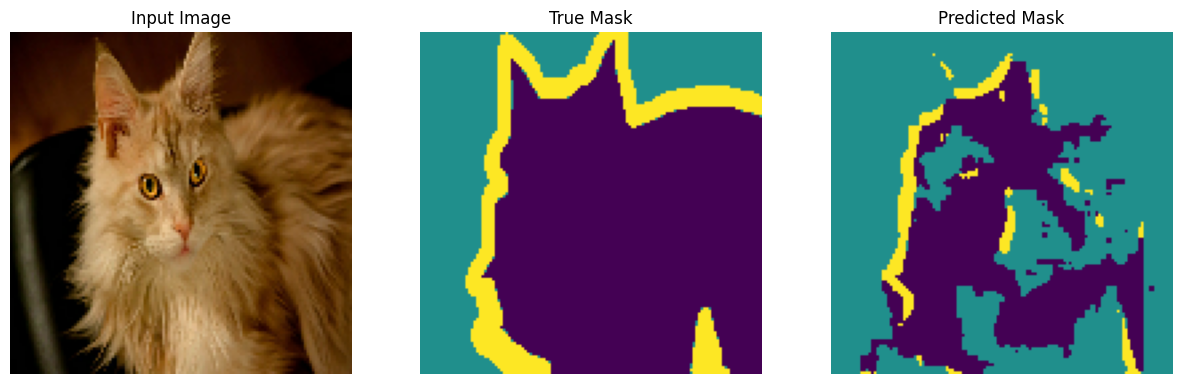

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


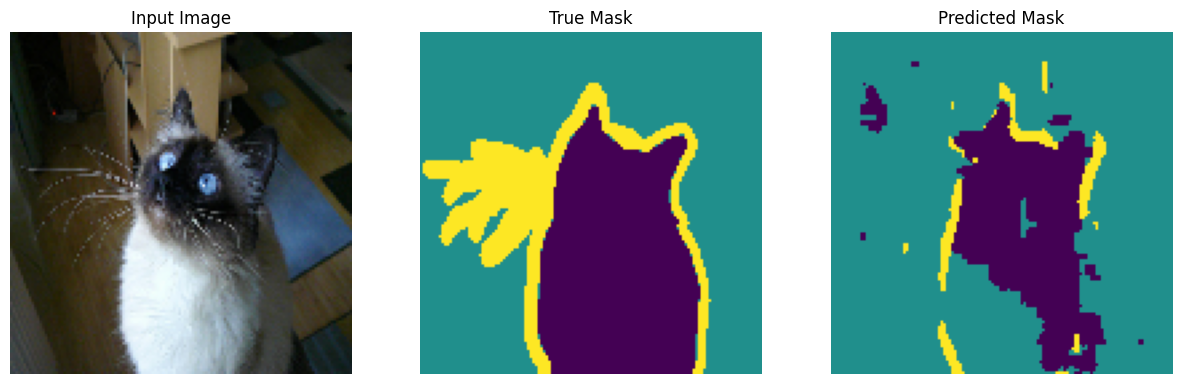

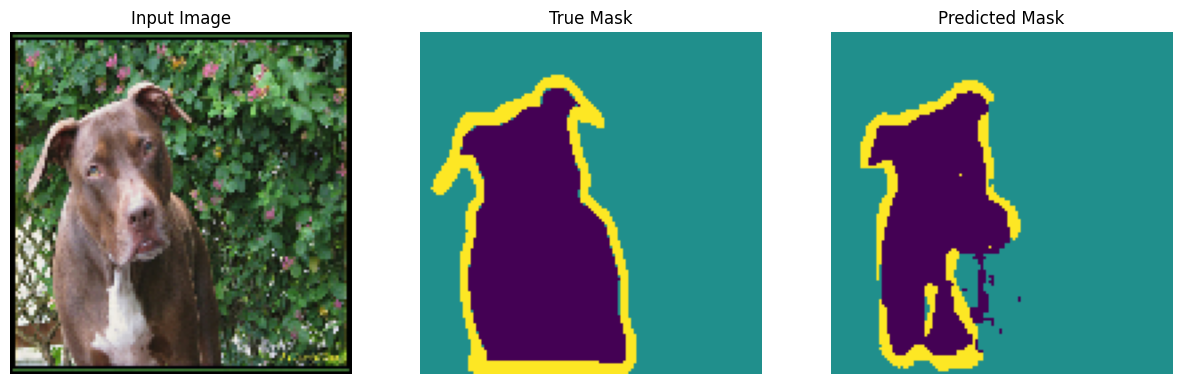

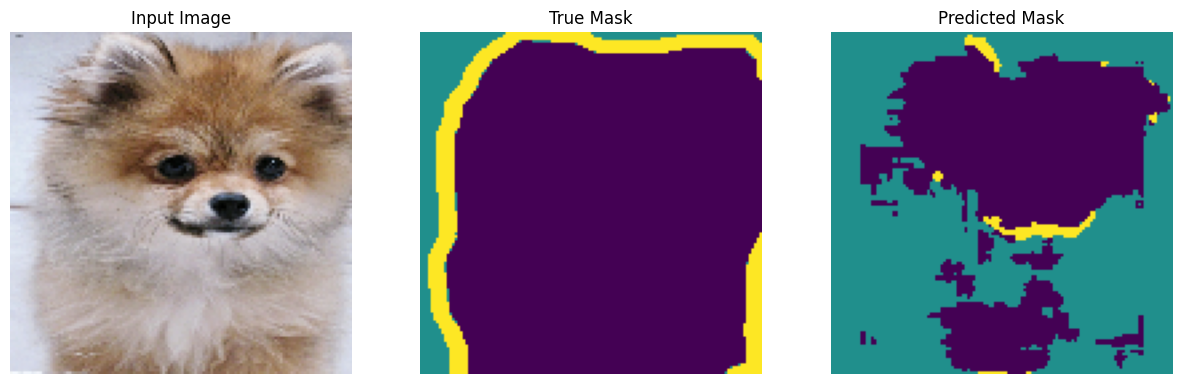

In [25]:
import matplotlib.pyplot as plt

# Función para mostrar una imagen, la máscara real y la predicha
def display_sample(display_list, titles=["Input Image", "True Mask", "Predicted Mask"]):
    plt.figure(figsize=(15, 5))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        image = tf.keras.utils.array_to_img(display_list[i])
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Obtener algunas muestras del conjunto de prueba
for image, mask in test.take(3):
    pred_mask = reconstructed_model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    for i in range(3):  # Mostrar las primeras 3 imágenes del batch
        display_sample([
            image[i],
            mask[i],
            pred_mask[i]
        ])